# RankNet

This is the generic implementation of RankNet on a synthetic dataset.

This model is applied to hotel imags in the other notebook.

![alt text](assets/siamese-net.png "Title")

In [1]:
import numpy as np

import keras
from keras import backend
from keras.layers import Activation, Add, Dense, Input, Lambda, Dropout, Subtract
from keras.models import Model, Sequential
from keras.utils import plot_model
%pylab inline

INPUT_DIM = 10


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Base Network

This is a scoring function (regression) that takes an images vector as input and outputs a scalar number. The Siamese model create two of these base networks to for higher and lower ranking images respectively.

In [2]:
def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(INPUT_DIM, input_shape=(input_dim,), activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(64, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(32, activation='relu'))
    seq.add(Dense(1))
    return seq

## Siamse Archecture

We create two instances of the base archecture and take the difference between their scalar outputs. We then pass the difference between a sigmoid function so that we can use binary-cross-entropy for the differntiable loss function.

In [3]:
def create_meta_network(input_dim, base_network):
    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))

    rel_score = base_network(input_a)
    irr_score = base_network(input_b)

    # subtract scores
    diff = Subtract()([rel_score, irr_score])

    # Pass difference through sigmoid function.
    prob = Activation("sigmoid")(diff)

    # Build model.
    model = Model(inputs = [input_a, input_b], outputs = prob)
    model.compile(optimizer = "adam", loss = "binary_crossentropy")

    return model

In [5]:
base_network = create_base_network(INPUT_DIM)
model = create_meta_network(INPUT_DIM, base_network)
model.summary()

plot_model(base_network, to_file='base.png')
plot_model(model, to_file='meta.png')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 1)                    2927      ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 subtract_1 (Subtract)       (None, 1)                    0         ['sequential_1[0][0]',  

AttributeError: module 'pydot' has no attribute 'InvocationException'

### Base Network

This can be any (scoring) function which outputs a scalar:
![base](base.png)

### Meta Network

This takes an instance of the base network and evalutes the pair on it:
![meta](meta.png)

## Synthetic Dataset

We generate two N dimensional datasets from an uniform distribution where one distribution is shift by a constant. This can be thought of as a good image and a less good image that we want to learn to differentiate.

In [6]:
from data import Dataloader
import metrics

In [7]:
# Loading the data
data_loader = Dataloader("../data/dataset_10") # Specify path to the dataset you want to load
X, Y= data_loader.load()

In [8]:
# Fake data.
N = 1000
SPLIT=750

X_1_train = X[0:SPLIT,:]
X_1_test = X[SPLIT:N,:]

X_2_train = Y[0:SPLIT,:]
X_2_test =  Y[SPLIT:N,:]


y = np.ones((X.shape[0], 1))

y_train = y[0:SPLIT,:]
y_test = y[SPLIT:N,:]

np.mean(X_1_train), np.mean(X_2_train)

(0.5148697290666666, 0.48496883640000005)

In [9]:
print(y)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [13]:
# Train model.

es=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=1, mode='auto')

NUM_EPOCHS = 100
BATCH_SIZE = 10
history = model.fit([X_1_train, X_2_train], y_train, 
                    validation_data=([X_1_test, X_2_test], y_test), 
                    batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, verbose = 1, callbacks=[es])

Epoch 1/100
75/75 [==============================] - 0s 3ms/step - loss: 0.5959 - val_loss: 0.6573
Epoch 2/100
75/75 [==============================] - 0s 2ms/step - loss: 0.5556 - val_loss: 0.6565
Epoch 3/100
75/75 [==============================] - 0s 2ms/step - loss: 0.5846 - val_loss: 0.6508
Epoch 4/100
75/75 [==============================] - 0s 2ms/step - loss: 0.5855 - val_loss: 0.6533
Epoch 5/100
75/75 [==============================] - 0s 3ms/step - loss: 0.5973 - val_loss: 0.6483
Epoch 6/100
75/75 [==============================] - 0s 3ms/step - loss: 0.5929 - val_loss: 0.6584
Epoch 7/100
75/75 [==============================] - 0s 3ms/step - loss: 0.5762 - val_loss: 0.6561
Epoch 7: early stopping


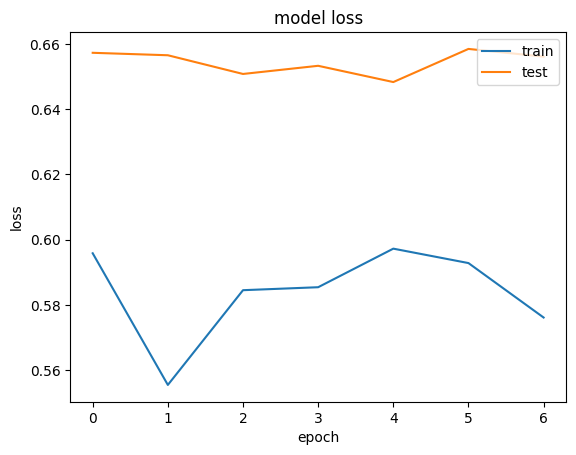

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [12]:
#the mean score of the high-rank distribution should be higher
np.mean(base_network.predict(X_1_test)), np.mean(base_network.predict(X_2_test))

8/8 [==============================] - 0s 2ms/step


(0.13492242, -0.107463755)

In [28]:
#AUC
(np.sum(base_network.predict(X_1_test) > base_network.predict(X_2_test))+0.0) / X_1_test.shape[0]

8/8 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 1ms/step


0.4